## Reduced equations for linear bending waves

The name "reduced equations for linear bending waves" comes from Lubow+Ogilvie 2000; it refers to Eqs. 8-9 in Lubow+Ogilvie 2000. This pair of coupled PDEs relates the tilt $\mathcal{W}$ and the internal torque $\mathcal{G}$:

$$ \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{G} - \alpha \Omega \mathcal{G}, $$
$$ \frac{\partial \mathcal{W}}{\partial t} = \frac{1}{\Sigma \Omega R^3 } \frac{\partial \mathcal{G}}{\partial R} - \left(\frac{\Omega_z^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{W}.$$

## Imports and normalizations

In [1]:
# %pip install fipy

# make 3D plots interactive
use_interactive_plots = False
if use_interactive_plots:
    %matplotlib notebook

import numpy as np
import time
import math
#import scipy.differentiate
import scipy.integrate as integ
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

For the reduced equations to be valid, we require $\alpha \lesssim c_s \sim h$.

In [2]:
cs = 0.2 # 0.02
alpha = 0.01 # 0.1 # 0.019

## Numerical derivatives

In [3]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$ (so $GM = 1$)
- $\Sigma_0 = 1$
- $c_s = 0.02$ (which implies $H = c_s/\Omega \sim 0.02$)
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [4]:
def Sigma(Rs):
    '''
    Returns the disk's background surface density profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    
    '''

    return 1 + (K-1)/2 * \
        (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))

In [5]:
## check shape of disk profile
#K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
#plt.plot(Rs_warp, Sigma(Rs_warp))

### Keplerian orbital frequency

Scale height, which depends on $\Omega$, is defined in the "Planet information" section below.

In [6]:
def OmegaK(Rs):
    '''
    Returns the Keplerian orbital frequency profile.
    Omega_K = sqrt(G*M_star / R^3)

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

## Planet information

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions?

### Laplace coefficients

In [7]:
def laplace_coeff_integrand(phi, x, j, s):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    j, s: See Eq. 6.67 of Murray & Dermott or Eq. 21 in Lubow+Ogilvie.
    
    '''
    
    num = np.cos(j*phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2) ** s
    
    return num / denom

def laplace_coeff(x, j, s):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x, j, s))[0]

Depending on whether the planet is inside ($R \gg a$; large $\alpha$) or outside ($R \ll a$; small $\alpha$) the disk, we can use the quadrupole approximations the Laplace coefficients:

In [8]:
def b0_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^0_{3/2} as a function of 
    alpha = R/a.
    
    If alpha << 1, set `limit` to "small". If alpha >> 1, set 
    `limit` to "large".
    
    '''
    
    if limit=="small":
        return 2 
    elif limit=="large":
        return 2/alpha**3
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

def b1_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^1_{3/2} as a function of 
    alpha = R/a.
    
    '''
    
    if limit=="small":
        return 3*alpha 
    elif limit=="large":
        return 3/alpha**4 
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

And let's check that our approximated functions are accurate:

In [9]:
# correctness checks
print("Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.")
x = 10
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="large"))

print("\nCorrectness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.")
x = 10
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="large"))

print("\nCorrectness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.")
x = .003
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="small"))

print("\nCorrectness check: for alpha << 1, b^0_{3/2} ~ 2.")
x = .0001
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="small"))


Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.
0.00030570812139446357
0.0003

Correctness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.
0.0020457128179197713
0.002

Correctness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.
0.009000151876993288
0.009000000000000001

Correctness check: for alpha << 1, b^0_{3/2} ~ 2.
2.000000045000001
2


### Orbital, epicyclic, and radial frequencies

(I use Eqs. 25-27 in Lubow+Ogilvie 2000.)

In [10]:
def Omega(Rs, Mp_in, a_in, Mp_out, a_out):
    '''
    Returns the disk's orbital frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp_in is the ratio of the inner planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a_in is the radius of the inner planet's orbit.
    
    Mp_out and a_out are defined similarly. To ``turn off'' either planet, set
    its mass to 0.

    '''

    OmegaKs = OmegaK(Rs)
    alphas_in = Rs/a_in
    alphas_out = Rs/a_out
    
    inner_pl_term = Mp_in/(2 * a_in**2 * Rs) * (alphas_in*b0_approx(Rs/a_in, "large") - \
                                      b1_approx(alphas_in, "large"))
    outer_pl_term = Mp_out/(2 * a_out**2 * Rs) * (alphas_out*b0_approx(Rs/a_out, "small") - \
                                      b1_approx(alphas_out, "small"))
    
    Omegas_sq = OmegaKs**2 + inner_pl_term + outer_pl_term
    
    return np.sqrt(Omegas_sq)

def Kappa(Rs, Mp_in, a_in, Mp_out, a_out):
    '''
    Returns the disk's epicyclic frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp_in is the ratio of the inner planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a_in is the radius of the inner planet's orbit.
    
    Mp_out and a_out are defined similarly. To ``turn off'' either planet, set
    its mass to 0.

    '''

    OmegaKs = OmegaK(Rs)
    alphas_in = Rs/a_in
    alphas_out = Rs/a_out
    
    inner_pl_term = Mp_in/(2 * a_in**2 * Rs) * (alphas_in*b0_approx(Rs/a_in, "large") - \
                                      2*b1_approx(alphas_in, "large"))
    outer_pl_term = Mp_out/(2 * a_out**2 * Rs) * (alphas_out*b0_approx(Rs/a_out, "small") - \
                                      2*b1_approx(alphas_out, "small"))
    
    kappas_sq = OmegaKs**2 + inner_pl_term + outer_pl_term
    
    return np.sqrt(kappas_sq)

def Omega_z(Rs, Mp_in, a_in, Mp_out, a_out):
    '''
    Returns the disk's vertical frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp_in is the ratio of the inner planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a_in is the radius of the inner planet's orbit.
    
    Mp_out and a_out are defined similarly. To ``turn off'' either planet, set
    its mass to 0.

    '''

    OmegaKs = OmegaK(Rs)
    alphas_in = Rs/a_in
    alphas_out = Rs/a_out
    
    inner_pl_term = Mp_in/(2 * a_in**2 * Rs) * alphas_in*b0_approx(alphas_in, "large")
    outer_pl_term = Mp_out/(2 * a_out**2 * Rs) * alphas_out*b0_approx(alphas_out, "small")
        
    Omegazs_sq = OmegaKs**2 + inner_pl_term + outer_pl_term
    
    return np.sqrt(Omegazs_sq)

### Disk scale height

In [11]:
def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)

## Integration functions

Boundary conditions:
- $\mathcal{G}(R) = 0$ at the inner and outer disk edges

Initial conditions:
- $\mathcal{W}(R_\text{min}, 0) = 0$ 
- $\mathcal{W}(R_\text{max}, 0) = 0.1$ 
- $\mathcal{W}(R,0)$ is some smooth function (eg, Gaussian integral)

In [12]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp_in, a_in, Mp_out, a_out):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp_in and a_in are the inner planet's mass and orbital radius respectively
    and similarly for the outer planet.
    
    '''
    
    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1")
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque) # length N+2
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque, Mp_in, a_in, Mp_out, a_out)
    
    dW_dRs_mid = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N
    dW_dRs = np.zeros(shape=Rs_torque.shape, dtype=complex)
    dW_dRs[1:-1] = dW_dRs_mid

    # sloshing term
    slosh_term = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs
    # external torque term
    Kappas = Kappa(Rs_torque, Mp_in, a_in, Mp_out, a_out)
    ext_term = (-1) * (Kappas**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Gs
    # viscous term
    visc_term = (-1) * alpha * Omegas * Gs 
    
    dG_dts = slosh_term + ext_term + visc_term
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp_in, a_in, Mp_out, a_out,\
          inner_BC="None", outer_BC="None"):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp_in and a_in are the inner planet's mass and orbital radius respectively
    and similarly for the outer planet.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.

    '''

    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1") 
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")
        
    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp) # length N+1
    Omegas = Omega(Rs_warp, Mp_in, a_in, Mp_out, a_out)
    
    # defines dG_dR for the W indices 0 through N
    dG_dRs = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N+1
    
    # internal torquing term
    int_term = dG_dRs / (Sigmas * Omegas * Rs_warp**3)
    # external torque term
    Omega_zs = Omega_z(Rs_warp, Mp_in, a_in, Mp_out, a_out)
    ext_term = (-1) * (Omega_zs**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Ws

    dW_dts = int_term + ext_term
    
    # enforce boundary conditions
    if inner_BC=="Dirichlet":
        dW_dts[0] = 0 
    elif inner_BC=="Neumann": # set W[0] equal to W[1]
        dW_dts[0] = (dW_dts[1] + Ws[1]) - Ws[0]
    elif inner_BC != "None":
        raise ValueError("inner_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    if outer_BC=="Dirichlet":
        dW_dts[-1] = 0 
    elif outer_BC=="Neumann": # set W[-1] equal to W[-2]
        dW_dts[-1] = (dW_dts[-2] + Ws[-2]) - Ws[-1]
    elif outer_BC != "None":
        raise ValueError("outer_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    return dW_dts

In [13]:
def evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, Mp_in, a_in, Mp_out, a_out):
    '''
    Use the predictor-corrector method to evolve G(R) forward by one timestep (dt).
    W and G are staggered in the R domain; see `dG_dt' or `dW_dt' function.
    
    Mp_in and a_in are the inner planet's mass and orbital radius respectively
    and similarly for the outer planet.

    '''

    # predictor step
    F1 = dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp_in, a_in, Mp_out, a_out)
    Gprimes = Gs + F1*dt

    # corrector step
    F2 = dG_dt(Rs_torque, Gprimes, Rs_warp, Ws, Mp_in, a_in, Mp_out, a_out)
    Gnexts = Gs + (F1+F2)/2 * dt

    return Gnexts

def evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, Mp_in, a_in, Mp_out, a_out, \
             inner_BC="None", outer_BC="None"):
    '''
    Use the predictor-corrector method to evolve W(R) forward by one timestep (dt).
    W and G are staggered in the R domain; see `dG_dt' or `dW_dt' function.
    
    Mp_in and a_in are the inner planet's mass and orbital radius respectively
    and similarly for the outer planet.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.
    
    '''

    # predictor step
    F1 = dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp_in, a_in, Mp_out, a_out, \
             inner_BC, outer_BC)
    Wprimes = Ws + F1*dt

    # corrector step
    F2 = dW_dt(Rs_torque, Gs, Rs_warp, Wprimes, Mp_in, a_in, Mp_out, a_out, \
             inner_BC, outer_BC)
    Wnexts = Ws + (F1+F2)/2 * dt

    return Wnexts

In [14]:
def integrate(Rs_torque, Gs, Rs_warp, Ws, ts, Mp_in, a_in, Mp_out, a_out,\
          inner_BC="None", outer_BC="None"):
    '''

    Integrate W(R) and G(R) over a given time domain (ts). Returns W(R) and 
    G(R) at the final timestep.
    
    W and G are staggered in the R domain; see `dG_dt' or `dW_dt' function.
    
    Mp_in and a_in are the inner planet's mass and orbital radius respectively
    and similarly for the outer planet.
        
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.
    See `dW_dt` function.

    '''

    # at each t, save the tilt at the middle of the R domain
    Wmids = np.empty_like(ts, dtype=complex)
    
    for i in range(len(ts)-1):
        t = ts[i]
        dt = ts[i+1] - ts[i]
        Gnexts = evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, Mp_in, a_in, Mp_out, a_out)
        Wnexts = evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, Mp_in, a_in, Mp_out, a_out,\
             inner_BC, outer_BC)

        Ws, Gs = Wnexts, Gnexts 
        Wmids[i] = np.take(Ws, Ws.size // 2)

    return Ws, Gs, Wmids

## Run a sim

Note that, from the $\frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G$, we can see that $t \sim \Omega^{-1} h^{-1}$ and $t \sim \Omega^{-1} \alpha^{-1} $ are both relevant timescales. This corresponds to $\sim$10-100 $\Omega^{-1}$.

In [15]:
# determine whether we add an inner and/or outer planet
use_inner_pl = False
use_outer_pl = False

Mp_in, a_in = 0, 0.45 # inner planet
Mp_out, a_out = 0, 4 # outer planet
    
if use_inner_pl:
    Mp_in = 0.1
if use_outer_pl:
    Mp_out = 0.1

In [28]:
# spatial and time domains
Rmin = 0.5
Rmax = 3.5 
Rmid = 1.5 # arbitrary point in middle of disk gap

# try Jiaru's "two-region" approach: simulate the inner and outer 
# parts of the disk separately, then connect them at Rmid
# if use_inner_pl:
#     Rmax = Rmid 
# if use_outer_pl:
#     Rmin = Rmid
    
DeltaR = 0.03
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
Rs_torque = np.zeros(shape=((num_Rs+1)))
Rs_torque[0] = Rs_warp[0] - DeltaR/2
Rs_torque[1:] = Rs_warp.copy() + DeltaR/2

tmin = 0
tmax = 100
Deltat = 0.001 # 0.03
num_ts = (int) ((tmax - tmin) / Deltat) + 1
ts = np.linspace(tmin, tmax, num_ts)

# disk that's initially flat but tilted
#Ws_init = np.zeros(shape=Rs_warp.shape, dtype=complex) + 0.1
#Ws_init.astype(complex)

# disk that's initially warped
Ws_init = 0.1 * np.cumsum(np.exp(-(Rs_warp-2)**2 / 2) / np.sqrt(2*np.pi)) * DeltaR
#Ws_init = (Ws_init + 0.5j*Ws_init).astype(complex)
#if use_outer_pl:
 #   Ws_init -= Ws_init[-1] # shifts W_init down so inclination=0 at outer edge
Ws_init.astype(complex)

Wmids = np.empty_like(Ws_init, dtype=complex)

#Ws = np.zeros(shape=Rs.shape) + (Rs-0.5)/30 # tilt W(R)
Gs_init = np.zeros(shape=Rs_torque.shape) # torque G(R)
Gs_init = Gs_init.astype(complex)

In [29]:
# set boundary conditions
inner_BC = "None"
outer_BC = "None"
if use_inner_pl:
    inner_BC = "Neumann"
if use_outer_pl:
    outer_BC = "Neumann"

resume_sim = False

start = time.time()

if resume_sim:
    ## use below line if you want to use a previous sim's results
    Ws_final, Gs_final, Wmids = integrate(Rs_torque, Gs_final, Rs_warp, Ws_final, ts, Mp_in, a_in,\
                Mp_out, a_out, inner_BC, outer_BC)
    tstop += tmax
else:
    Ws_final, Gs_final, Wmids = integrate(Rs_torque, Gs_init, Rs_warp, Ws_init, ts, Mp_in, a_in,\
                Mp_out, a_out, inner_BC, outer_BC)
    tstop = tmax


end = time.time()
print("Elapsed time:", np.round(end - start, 2))

Elapsed time: 10.53


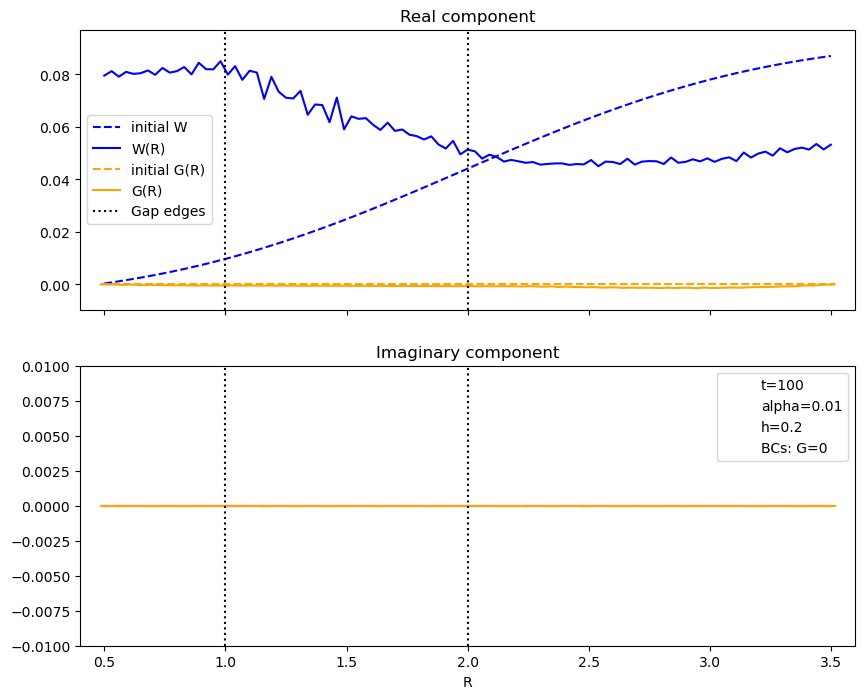

In [30]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.set_facecolor("white")

axs[0].plot(Rs_warp, Ws_init.real, c="blue", ls="--", label="initial W")
axs[0].plot(Rs_warp, Ws_final.real, c="blue", label="W(R)")
axs[0].plot(Rs_torque, Gs_init.real, c="orange", ls="--", label="initial G(R)")
axs[0].plot(Rs_torque, Gs_final.real, c="orange", label="G(R)")

ymin, ymax= min(min(Ws_init.real), min(Ws_final.real)) - .01, max(max(Ws_init.real), max(Ws_final.real)) + .01
R_a, R_b = 1, 2
axs[0].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[0].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

axs[0].set_ylim(ymin,ymax)

axs[1].scatter([],[], s=0, label="t=" + str(tstop))
axs[1].scatter([],[], s=0, label="alpha=" + str(alpha))
axs[1].scatter([],[], s=0, label="h=" + str(cs))
axs[1].scatter([],[], s=0, label="BCs: G=0")
if use_inner_pl:
    axs[1].scatter([],[], s=0, label="Mp_in=" + str(Mp_in))
    axs[1].scatter([],[], s=0, label="a_in=" + str(a_in))
if use_outer_pl:
    axs[1].scatter([],[], s=0, label="Mp_out=" + str(Mp_out))
    axs[1].scatter([],[], s=0, label="a_out=" + str(a_out))

axs[0].legend()
axs[0].set_title("Real component")

axs[1].plot(Rs_warp, Ws_init.imag, c="blue", ls="--")#, label="initial W")
axs[1].plot(Rs_warp, Ws_final.imag, c="blue")#, label="W(R)")
axs[1].plot(Rs_torque, Gs_init.imag, c="orange", ls="--")#, label="initial G(R)")
axs[1].plot(Rs_torque, Gs_final.imag, c="orange")#, label="G(R)")

ymin, ymax= min(Ws_final.imag) - .01, max(max(Ws_init.imag),max(Ws_final.imag)) + .01
R_a, R_b = 1, 2
axs[1].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[1].vlines(R_b, ymin, ymax, color="black", linestyle=":")#, label="Gap edges")

axs[1].set_xlim(Rmin - 0.1, Rmax + 0.1)
axs[1].set_ylim(ymin,ymax)

axs[1].legend()
axs[1].set_title("Imaginary component")

axs[1].set_xlabel("R")

save_figs = False

if save_figs:
    filepath = "Figures/t=" + str(tstop) + ".png"
    plt.savefig(filepath)

plt.show()

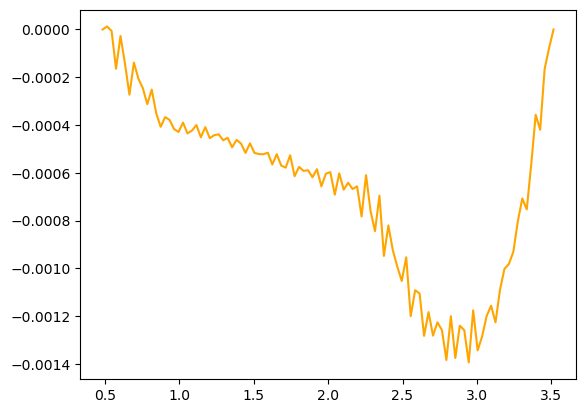

In [31]:
plt.plot(Rs_torque, Gs_final.real, c="orange", label="G(R)")


In [48]:
# check how much the disk has flattened (ratio should be ~1e-2)
# Wdiff_ratio = (max(Ws_final) - min(Ws_final)) / (Ws_init[-1] - Ws_init[0])
# print("Ratio of final W difference to initial: {:.2E}".format(Wdiff_ratio.real))

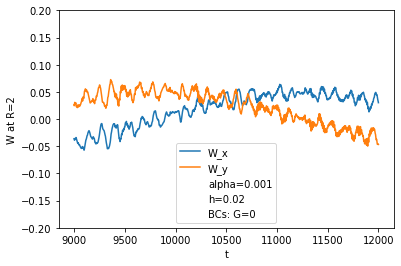

In [81]:
fig = plt.figure()
fig.set_facecolor("white")

plt.plot(9000 + ts[0:-1:100], Wmids.real[0:-1:100], label="W_x")
plt.plot(9000 + ts[0:-1:100], Wmids.imag[0:-1:100], label="W_y")

plt.scatter([],[], s=0, label="alpha=" + str(alpha))
plt.scatter([],[], s=0, label="h=" + str(cs))
plt.scatter([],[], s=0, label="BCs: G=0")

plt.xlabel("t")
plt.ylabel("W at R=2")
plt.ylim(-0.2, 0.2)


plt.legend()

if save_figs:
    plt.savefig("Figures/Wmid_evoln_t=" + str(tstop) + ".png")

plt.show()


## Compare to steady-state solution

### plug into PDEs

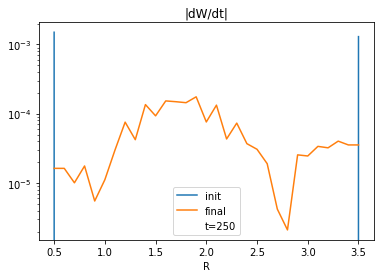

In [88]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor("white")

dWdts_init = dW_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp_in, a_in, Mp_out, a_out, \
       inner_BC, outer_BC)

plt.plot(Rs_warp, np.abs(dWdts_init), label="init")

dWdts_final = dW_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp_in, a_in, Mp_out, a_out, \
       inner_BC, outer_BC)

plt.plot(Rs_warp, np.abs(dWdts_final), label="final")

plt.scatter([],[], s=0, label="t=" + str(tstop))

plt.xlabel("R")
plt.yscale("log")
plt.title("|dW/dt|")

plt.legend()
if save_figs:
    filepath = "Figures/dWdt_t=" + str(tstop) + ".png"
    plt.savefig(filepath)
plt.show()

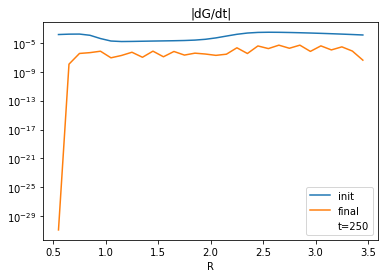

In [89]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor("white")

dGdts_init = dG_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp_in, a_in, Mp_out, a_out)

plt.plot(Rs_torque, np.abs(dGdts_init), label="init")

dGdts_final = dG_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp_in, a_in, Mp_out, a_out)

plt.plot(Rs_torque, np.abs(dGdts_final), label="final")

plt.scatter([],[], s=0, label="t=" + str(tstop))

plt.xlabel("R")
plt.yscale("log")
plt.title("|dG/dt|")

plt.legend()
if save_figs:
    filepath = "Figures/dGdt_t=" + str(tstop) + ".png"
    plt.savefig(filepath)
plt.show()

### compare to dW/dR

In [23]:
# check that, if Neumann conditions are on, W changes at boundaries
# print(Ws[0] - Ws_final[0])
# print(Ws[-1] - Ws_final[-1])

In [24]:
#Gs_final[-1]

In [25]:
#plt.plot(Gs_final)

In [26]:
def dW_dR_ss(Rs):
    '''
    Computes the steady-state value of dW_dR. Assumes no external torque, 
    so we can write G(R) = constant.
    
    '''
    
    return alpha * Omega(Rs_warp) * Gs_final[-1] / \
            (Sigma(Rs) * scaleHeight(Rs)**2 * Omega(Rs)**3 * Rs**3 / 4)


# fig = plt.figure()
# fig.set_facecolor("white")

# plt.plot(Rs_warp, np.gradient(Ws_final, Rs_warp), label="sim")
# # in steady-state, G should be constant
# plt.plot(Rs_warp, dW_dR_ss(Rs_warp), label="steady state")

# plt.scatter([],[], s=0, label="t=" + str(tmax))
# plt.scatter([],[], s=0, label="alpha=" + str(alpha))

# plt.title("dW/dR")
# plt.legend()

## Visualize in 3D

Given the tilt $\mathcal{W}(R)$, visualize the disk in 3D space.

In [61]:
def plot_disk(Ws, Rs_warp):
    '''
    Given values of the tilt variable W over the domain Rs_warp, 
    plot the disk shape in 3D space.
    
    '''
    
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor("white")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    maxcoord = 3.6
    zlim = 1
    ax.set_xlim(-maxcoord, maxcoord)
    ax.set_ylim(-maxcoord, maxcoord)
    ax.set_zlim(-zlim, zlim)
    
    lxs = Ws.real
    lys = Ws.imag
    
    thetas = np.linspace(0, 2*np.pi, num=50)
    thetas = np.reshape(thetas, (1, len(thetas)))
    
    # plot each ring separately
    for i in range(len(Rs_warp)):
        R = Rs_warp[i]
        lx = lxs[i]
        ly = lys[i]
        
        # 
        a_vec = np.array((-ly, lx, 0)) / np.sqrt(lx**2 + ly**2) # normalize
        a_vec = np.reshape(a_vec, (3, 1))
        
        b_vec = np.array((-lx, -ly, lx**2 + ly**2)) / np.sqrt(2*lx**2 + 2*ly**2)
        b_vec = np.reshape(b_vec, (3, 1))
        
        coords = R * (a_vec*np.cos(thetas) + b_vec*np.sin(thetas))
        ax.plot(coords[0], coords[1], coords[2], alpha=0.8, color="gray")
        
    plt.title("Disk visualization")
    plt.show()
    

In [62]:
start = time.time()
plot_disk(Ws_final, Rs_warp)
end = time.time()
print("Elapsed time:", np.round(end - start, 2))

<IPython.core.display.Javascript object>

Elapsed time: 0.02
